
#### **1. 데이터 준비**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# matplotlib 한글 폰트 오류 해결
!pip install koreanize-matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 50.1 MB/s eta 0:00:00


In [ ]:
# 출력되는 행 전체보기 모드
pd.options.display.max_rows = None

In [ ]:
# 데이터 불러오기
data = pd.read_excel('멋사 지원데이터 - 공유용.xlsx',sheet_name=1)

# 데이터 5개만 확인
data.head(5)

In [ ]:
# 행, 열 수 확인
data.shape

(10466, 33)

In [ ]:
# raw데이터 복사해서 사용
dt = data.copy()
dt.head(5)



---



#### **2. 전처리**

##### **2-1. TEST 데이터 전처리**

2-1-1. likelion 계정 삭제

In [ ]:
# likelion-test 데이터 확인
cols1 = ['사용 이메일', '소속']

likelion_mask = dt[cols1].apply(lambda col: col.str.contains('likelion', case=False, na=False)).any(axis=1)

dt[likelion_mask][['사용 이메일', '소속']]

In [ ]:
# likelion-test 데이터 444행 삭제
dt = dt[~likelion_mask]
dt.shape

(10022, 33)



---



2-1-2. 테스트 데이터가 포함된 컬럼명 확인

In [ ]:
# "테스트" 또는 "test" 확인
keywords = ['테스트', 'test']

# 조건에 해당하는 컬럼명만 수집
matching_cols = []

for col in dt.columns:
    if dt[col].astype(str).str.contains('|'.join(keywords), case=False, na=False).any():
        matching_cols.append(col)

print(matching_cols)

['지원취소 사유', '사용 이메일', '소속', '직무', '전공', 'Q1.', 'Q2.', 'Q3.', 'Q4.', 'Q5.']


In [ ]:
# 멋사 데이터 확인
testText_mask = dt[cols2].apply(lambda col: col.str.contains('멋사|멋쟁이', case=False, na=False)).any(axis=1)

dt[testText_mask][['지원취소 사유', '사용 이메일', '소속', '직무', '전공', 'Q1.', 'Q2.']]

In [ ]:
print(len(dt[testText_mask]))
print(dt[testText_mask].index)

12
Index([207, 519, 829, 1290, 1694, 2322, 3414, 4065, 6696, 7357, 9035, 9928], dtype='int64')


In [ ]:
# 519, 1694, 2322 인덱스 외 삭제할 인덱스 목록
drop_index = [207, 829, 1290, 3414, 4065, 6696, 7357, 9035, 9928]

# 해당 인덱스 삭제
dt = dt.drop(index=drop_index)

In [ ]:
dt.shape

(9848, 33)

In [ ]:
# 테스트 데이터 완료
#dt.to_excel('테스트 데이터 제거 완료.xlsx')



---



##### **2-2. 결측값 전처리**

결측 확인

In [ ]:
dt.info()

In [ ]:
dt.isnull().sum()

###### **2-2-1.나이 컬럼 결측값 전처리**

나이 결측값 0으로 채우기

In [ ]:
dt['나이'] = dt['나이'].fillna(0).astype(int)
dt['나이'].isnull().sum()

np.int64(0)

125살 60개 결측값 0으로 처리

In [ ]:
# 125살 60개 결측값으로 처리
dt['나이'] = dt['나이'].replace(125, 0)
print(dt.query('나이 == 125'))

In [ ]:
# 나이 결측값 5468개
len(dt.query('나이 == 0'))

5468

나이를 연령대로 분류

In [ ]:
# 나이대 생성 함수 정의
def get_age(age):
    if age == 0:
        return '응답없음'            # 9999는 결측값 대체 → '응답없음'으로 분류
    if 10 <= age < 20:
        return '10대'
    elif 20 <= age < 30:
        return '20대'
    elif 30 <= age < 40:
        return '30대'
    elif 40 <= age < 50:
        return '40대'               # 40~49세 → 40대
    elif 50 <= age < 60:
        return '50대'               # 50~59세 → 50대
    elif 60 <= age:
        return '60대 이상'          # 60~99세 → 60대 이상
    else:
        return '응답없음'

# '나이' 컬럼에 함수 적용해서 '나이대' 컬럼 생성
dt['나이대'] = dt['나이'].apply(get_age)
dt['나이대'].value_counts().sort_index()

**나이 결측인 경우 전처리 방법**: '나이' 값이 존재하는 데이터로부터 '현재 직업' 컬럼을 기준으로 나이 통계값을 구한 뒤, 나이가 결측인 데이터의 '현재 직업'을 매칭하여 연령대 생성

In [ ]:
age_exist = dt[dt['나이'] != 0]
age_exist.shape

(4380, 34)

In [ ]:
age_exist.groupby('직무 및 소속 등 개인 상황이 어떻게 되시나요?')['직무 및 소속 등 개인 상황이 어떻게 되시나요?'].value_counts()

In [ ]:
age_exist.groupby('직무 및 소속 등 개인 상황이 어떻게 되시나요?')['나이'].describe()

,count,mean,std,min,25%,50%,75%,max
직무 및 소속 등 개인 상황이 어떻게 되시나요?,,,,,,,,
대학생 / 1학년 / 재학중 / 대학원 진학 고려하지 않음,17.0,23.058824,7.189146,17.0,20.00,21.0,24.00,49.0
대학생 / 1학년 / 재학중 / 대학원 진학 희망함,9.0,21.666667,3.840573,19.0,19.00,20.0,23.00,31.0
대학생 / 1학년 / 휴학중 / 대학원 진학 고려하지 않음,6.0,21.500000,2.073644,19.0,20.25,21.0,23.25,24.0
대학생 / 1학년 / 휴학중 / 대학원 진학 희망함,2.0,33.500000,17.677670,21.0,27.25,33.5,39.75,46.0
대학생 / 2학년 / 수료 / 대학원 진학 고려하지 않음,2.0,23.500000,3.535534,21.0,22.25,23.5,24.75,26.0
대학생 / 2학년 / 재학중 / 대학원 진학 고려하지 않음,26.0,22.038462,1.455494,19.0,21.00,22.0,23.00,25.0
대학생 / 2학년 / 재학중 / 대학원 진학 희망함,6.0,20.666667,1.366260,19.0,19.50,21.0,21.75,22.0
대학생 / 2학년 / 졸업예정 / 대학원 진학 고려하지 않음,7.0,23.000000,1.825742,20.0,22.00,24.0,24.00,25.0
대학생 / 2학년 / 휴학중 / 대학원 진학 고려하지 않음,9.0,21.666667,1.000000,20.0,21.00,22.0,22.00,23.0


In [ ]:
#상위 카테고리를 '현재 직업' 컬럼에 할당
age_exist['현재 직업'] = age_exist['직무 및 소속 등 개인 상황이 어떻게 되시나요?'].str.split('/').str[0].str.strip()
age_exist['현재 직업'].value_counts()

,count
현재 직업,
취업 준비생,1460
대학생,727
직장인,295
창업 준비생,152
대학원생,36


In [ ]:
# 현재 직업을 기준으로 그룹화하여 나이 통계값 확인
age_exist.groupby('현재 직업')['나이'].agg(['min', 'max', 'count', 'mean', 'median'])

,min,max,count,mean,median
현재 직업,,,,,
대학생,17,53,727,23.888583,24.0
대학원생,23,47,36,29.277778,27.5
직장인,22,73,295,34.935593,32.0
창업 준비생,16,74,152,37.236842,34.0
취업 준비생,15,73,1460,28.303425,27.0


'현재 직업'별로 '나이' 분포를 boxplot으로 시각화

/tmp/ipython-input-36-2604080113.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=age_exist, x='현재 직업', y='나이', palette='Set3')


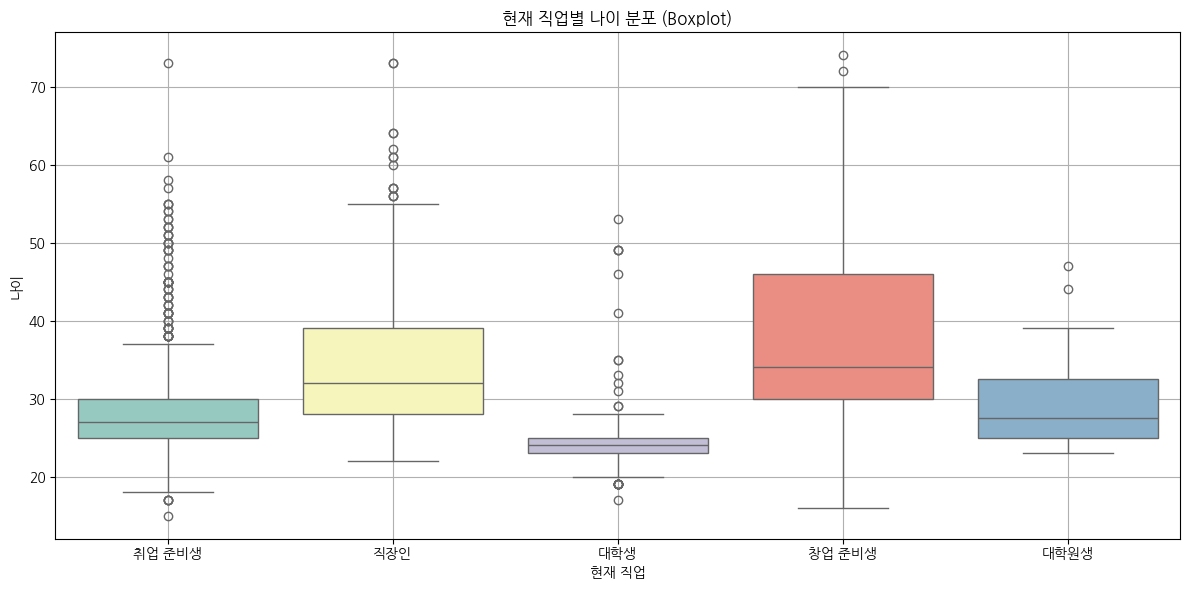

In [ ]:
# 그래프 크기 설정 (가로 12, 세로 6 인치)
plt.figure(figsize=(12, 6))

# '현재 직업'별로 '나이' 분포를 boxplot으로 시각화
sns.boxplot(data=age_exist, x='현재 직업', y='나이', palette='Set3')

# 그래프 제목 설정
plt.title('현재 직업별 나이 분포 (Boxplot)')

# 배경에 격자(grid) 표시
plt.grid(True)

# 레이아웃 자동 조정 (그래프가 잘리는 것 방지)
plt.tight_layout()

# 그래프 출력
plt.show()

IQR

In [ ]:
# 직업별로 적용
def remove_outliers(df, group_col, target_col):
    cleaned_df = pd.DataFrame()

    for group, subset in df.groupby(group_col):
        Q1 = subset[target_col].quantile(0.25)
        Q3 = subset[target_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # 이상치 제외
        cleaned_subset = subset[(subset[target_col] >= lower) & (subset[target_col] <= upper)]
        cleaned_df = pd.concat([cleaned_df, cleaned_subset])

    return cleaned_df

# 예시 실행
cleaned_age_exist = remove_outliers(age_exist, '현재 직업', '나이')

In [ ]:
cleaned_age_exist.shape

(2551, 35)

/tmp/ipython-input-39-210919508.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cleaned_age_exist, x='현재 직업', y='나이', palette='Set3')


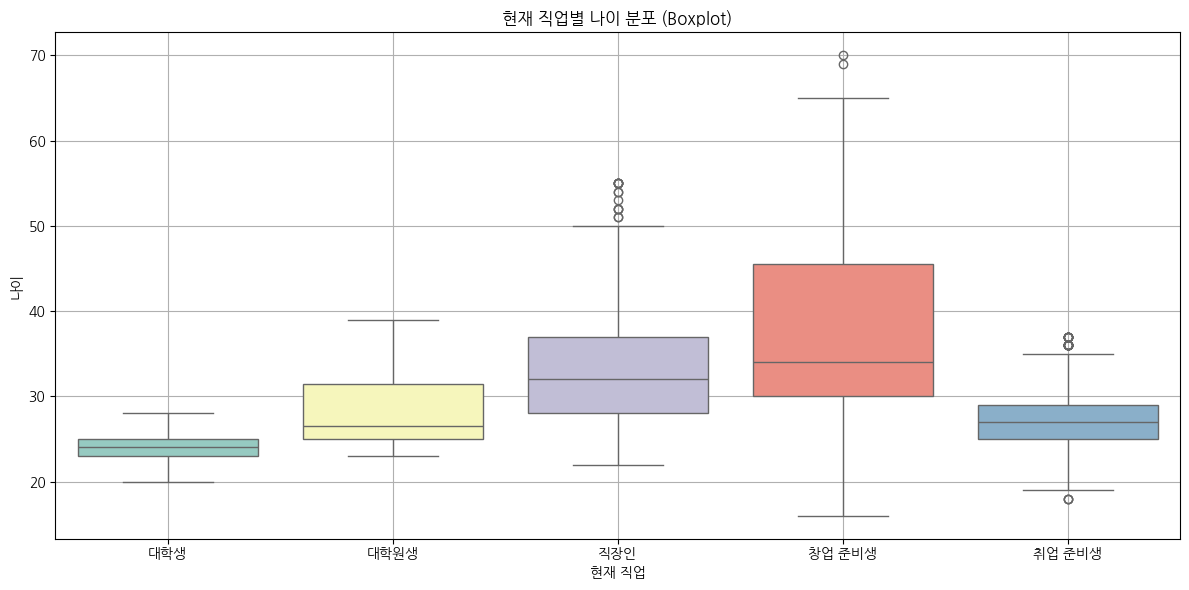

In [ ]:
# 그래프 크기 설정 (가로 12, 세로 6 인치)
plt.figure(figsize=(12, 6))

# '현재 직업'별로 '나이' 분포를 boxplot으로 시각화
sns.boxplot(data=cleaned_age_exist, x='현재 직업', y='나이', palette='Set3')

# 그래프 제목 설정
plt.title('현재 직업별 나이 분포 (Boxplot)')

# 배경에 격자(grid) 표시
plt.grid(True)

# 레이아웃 자동 조정 (그래프가 잘리는 것 방지)
plt.tight_layout()

# 그래프 출력
plt.show()

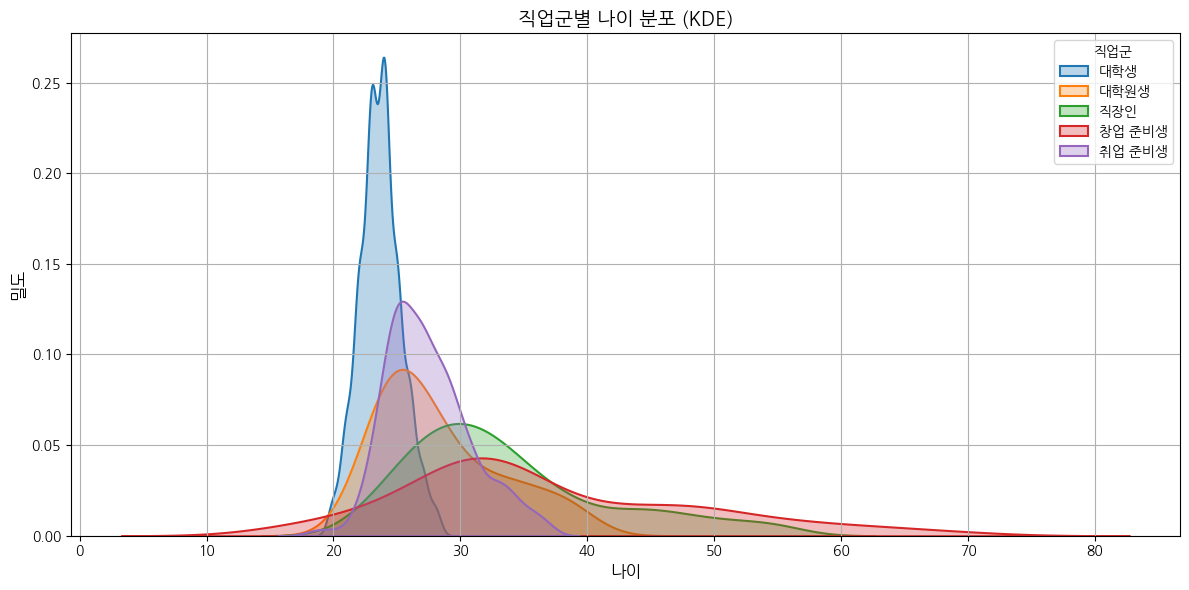

In [ ]:
# KDE plot
plt.figure(figsize=(12, 6))  # 그래프 크기 설정 (가로 12인치, 세로 6인치)

# '현재 직업'의 고유값(직업군)별로 나눠서 개별 KDE 곡선 그리기
for job in cleaned_age_exist['현재 직업'].unique():
    subset = cleaned_age_exist[cleaned_age_exist['현재 직업'] == job]  # 특정 직업군에 해당하는 데이터만 필터링
    sns.kdeplot(
        data=subset,
        x='나이',         # x축에 나이
        label=job,        # 범례 직업군 이름 표시
        fill=True,        # 곡선 아래 색칠
        alpha=0.3,        # 색 투명도
        linewidth=1.5     # 선 두께
    )


plt.title('직업군별 나이 분포 (KDE)', fontsize=14)
plt.xlabel('나이', fontsize=12)
plt.ylabel('밀도', fontsize=12)
plt.legend(title='직업군')  # 범례 제목 설정
plt.grid(True)              # 배경에 격자 표시
plt.tight_layout()          # 레이아웃 자동 조정 (겹침 방지)
plt.show()                  # 그래프 출력

**분석해석**

대학생: 매우 뾰족하고 좁은 범위 -> 평균값 사용

대학원생: 완만한 분포 -> 평균값 사용

취업 준비생: 왜곡 적고 좌우 분포 비교적 대칭 -> 평균값 사용

직장인: 분포 넓고 비대칭 -> 중앙값 사용

창업 준비생: 이상치 많아 평균/중앙값은 왜곡 위험 있음 + 주 타겟은 아니기 때문에 이상치로 취급

In [ ]:
cleaned_age_exist.groupby('현재 직업')['나이'].describe()

,count,mean,std,min,25%,50%,75%,max
현재 직업,,,,,,,,
대학생,703.0,23.682788,1.620850,20.0,23.0,24.0,25.0,28.0
대학원생,34.0,28.323529,4.752802,23.0,25.0,26.5,31.5,39.0
직장인,281.0,33.626335,7.887097,22.0,28.0,32.0,37.0,55.0
창업 준비생,150.0,36.760000,11.555922,16.0,30.0,34.0,45.5,70.0
취업 준비생,1383.0,27.428055,3.356376,18.0,25.0,27.0,29.0,37.0


In [ ]:
cleaned_age_exist.groupby('현재 직업')['나이'].median()

,나이
현재 직업,
대학생,24.0
대학원생,26.5
직장인,32.0
창업 준비생,34.0
취업 준비생,27.0



**현재 직업별 나이대 정의**

대학생 -> 20대

대학원생 -> 20대

직장인 -> 30대

취업 준비생 -> 20대

In [ ]:
dt['현재 직업'] = dt['직무 및 소속 등 개인 상황이 어떻게 되시나요?'].str.split('/').str[0].str.strip()

# '현재 직업' 열의 값별로 빈도수 세기
dt['현재 직업'].value_counts(dropna=False)

,count
현재 직업,
NaN,3999
취업 준비생,3059
대학생,1453
직장인,777
창업 준비생,489
대학원생,69
추가지원,2


나이대 '응답없음' 데이터 중 '현재 직업'을 매칭하여 '나이대' 컬럼 채우기  5468개 -> 2628개

In [ ]:
#응답없음 데이터 수 확인
dt['나이대'].value_counts()

,count
나이대,
응답없음,5468
20대,2993
30대,873
40대,194
10대,152
50대,121
60대 이상,47


In [ ]:
# '나이대' 응답없을 경우 '현재 직업' 조건에 맞게 나이대 채워주는 함수
def fill_age_group(row):
    if row['나이대'] == '응답없음':
        job = row['현재 직업']
        if job in ['대학생', '대학원생', '취업 준비생']:
            return '20대'
        elif job == '직장인':
            return '30대'
    return row['나이대']  # 기존 값 유지

# 적용
dt['나이대'] = dt.apply(fill_age_group, axis=1)

#응답없음 채운 후 나이대별 빈도
dt['나이대'].value_counts().sort_index()

,count
나이대,
10대,152
20대,5351
30대,1355
40대,194
50대,121
60대 이상,47
응답없음,2628


In [ ]:
# 전처리 완료
dt.to_excel('전처리 완료.xlsx')



---



#### DAS 지원자 분석

In [ ]:
# 클래스명에 das가 포함되어 있으면 출력
das = dt[dt['클래스'].str.contains('DAS', na=False)]
das.shape

In [ ]:
# 컬럼별 데이터 형식 확인
das.info()

In [ ]:
# object 타입인 열만 선택
obj_cols = das.select_dtypes(include='object').columns

# object 타입인 열 결측값을 '응답없음'으로 채움
das[obj_cols] = das[obj_cols].fillna('응답없음')

# null값 확인
das[obj_cols].isnull().sum()

##### 성별

In [ ]:
das['성별'].value_counts().sort_index()

##### 나이대

In [ ]:
das['나이대'].value_counts().sort_index()

##### 현재직업분석

In [ ]:
das['현재 직업'].value_counts()



---



#### 자소서 분석



*   KoNLPy: 한국어 자연어처리 라이브러리
*   Okt: 형태소 분석기, 명사 추출에 사용
*   CountVectorizer: 등장 빈도 분석에 사용





In [ ]:
#konlpy라이브러이 설치
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 496.6/496.6 kB 25.0 MB/s eta 0:00:00


In [ ]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#자소서 항목 결측값 확인
das[['Q1.','Q2.', 'Q3.', 'Q4.', 'Q5.']].isna().sum()

,0
Q1.,730
Q2.,754
Q3.,767
Q4.,1019
Q5.,1154


In [ ]:
#결측값 응답없음으로 처리
das.loc[:, 'Q1.':'Q5.'] = das.loc[:, 'Q1.':'Q5.'].fillna('응답없음')

/tmp/ipython-input-8-722259254.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['응답없음' '응답없음' '응답없음' ... '응답없음' '응답없음' '응답없음']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  das.loc[:, 'Q1.':'Q5.'] = das.loc[:, 'Q1.':'Q5.'].fillna('응답없음')


In [ ]:
das[['Q1.','Q2.', 'Q3.', 'Q4.', 'Q5.']].isna().sum()

,0
Q1.,0
Q2.,0
Q3.,0
Q4.,0
Q5.,0




---



##### 이루고 싶은 목표 항목을 통해 니즈 도출

In [ ]:
# 목표 항목 추출
goal1 = das.query('월 == "11월" and `Q2.` != "응답없음"')['Q2.']
goal2 = das.query('월 == "12월" and `Q2.` != "응답없음"')['Q2.']

goal_combined = pd.concat([goal1, goal2], ignore_index=True)

In [ ]:
# 1. 대상 열만 추출하고 결측치 제거
# - goal_combined 리스트의 각 항목을 문자열(str)로 변환하여 텍스트 리스트 생성
target_texts3 = goal_combined
target_texts3 = [str(t) for t in target_texts3]

# 2. 형태소 분석기로 명사 추출
# - 앞에서 정의한 extract_nouns 함수를 사용하여 각 문장에서 명사만 추출
processed_texts3 = [extract_nouns(text) for text in target_texts3]

# 3. 단어 등장 횟수 세기
# - CountVectorizer를 사용하여 명사만 추출된 텍스트를 벡터화 (단어 빈도수 행렬 생성)
X3 = vectorizer.fit_transform(processed_texts3)

# - 전체 문서에서 단어별 등장 횟수 합계 계산
word_counts3 = X3.sum(axis=0)

# - 단어와 등장 횟수를 튜플 형태로 리스트에 저장
word_freq3 = [(word, word_counts3[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

# - 등장 횟수를 기준으로 내림차순 정렬
word_freq3 = sorted(word_freq3, key=lambda x: x[1], reverse=True)

# 4. 결과 DataFrame 생성
# - 단어와 등장 횟수를 pandas DataFrame으로 저장
df_word_freq3 = pd.DataFrame(word_freq3, columns=["단어", "등장횟수"])
df_word_freq3

In [ ]:
#폰트 설치
#!apt-get -qq install fonts-nanum

In [ ]:
#폰트 경로
#import matplotlib.font_manager as fm
#font_paths = [f.fname for f in fm.fontManager.ttflist if 'Nanum' in f.name]
#print(font_paths)

['/usr/local/lib/python3.11/dist-packages/koreanize_matplotlib/fonts/NanumGothic.ttf', '/usr/local/lib/python3.11/dist-packages/koreanize_matplotlib/fonts/NanumGothicExtraBold.ttf', '/usr/local/lib/python3.11/dist-packages/koreanize_matplotlib/fonts/NanumGothicBold.ttf', '/usr/local/lib/python3.11/dist-packages/koreanize_matplotlib/fonts/NanumGothicLight.ttf']


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# 예시로 사용할 폰트 경로
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 단어 빈도 딕셔너리
word_freq_dict = dict(zip(top30['단어'], top30['등장횟수']))

# 워드클라우드 생성 (마스크 없이, 빈도 강조 중심)
wordcloud = WordCloud(
    font_path=font_path,
    background_color='white',
    width=800,
    height=400,
    max_words=200,
    max_font_size=250,   # 빈도가 높은 단어가 시각적으로 큼
    min_font_size=15,
    scale=3,             # 빈도에 따른 크기 차이 더 강조
    prefer_horizontal=0.9
).generate_from_frequencies(word_freq_dict)

# 시각화
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("단어 클라우드 (빈도 강조)", fontsize=18)
plt.show()

In [ ]:
df_word_freq3 = pd.read_excel('목표.xlsx')

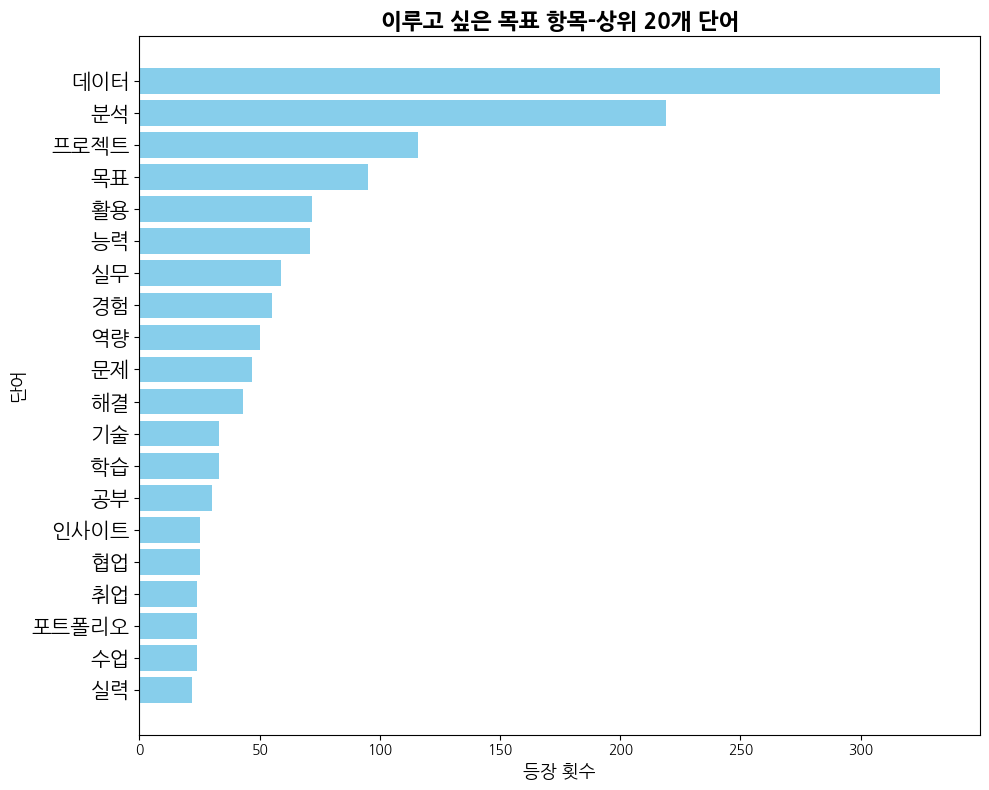

In [ ]:
# 1. 상위 30개 단어 선택
top30 = df_word_freq3.head(20)

# 2. 가로 막대그래프 그리기
plt.figure(figsize=(10, 8))
plt.barh(top30['단어'], top30['등장횟수'], color='skyblue')
plt.xlabel('등장 횟수', fontsize=13)
plt.ylabel('단어', fontsize=13)
plt.title('이루고 싶은 목표 항목-상위 20개 단어', fontsize=16, fontweight='bold')

# y축 단어 텍스트 크기 키우기
plt.yticks(fontsize=15)  # 원하는 크기로 조정 (예: 13~16)


plt.gca().invert_yaxis()  # 가장 빈도 높은 단어가 위로 오도록
plt.tight_layout()
plt.show()